In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotnine
from plotnine import *

import itertools
import difflib
import sys
import requests
from tqdm.auto import tqdm
from pprint import pprint

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [6]:
# read data
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')
GYGA_weighted_by_area_ratio = pd.read_csv('./result_csv/GYGA_weighted_by_area_ratio.csv')

GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl')
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = pd.read_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.csv')

GAEZ_actual_forced_with_Yearbook = pd.read_pickle('./result_csv/GAEZ_actual_forced_with_Yearbook.pkl')
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot = pd.read_csv('./result_csv/GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.csv')

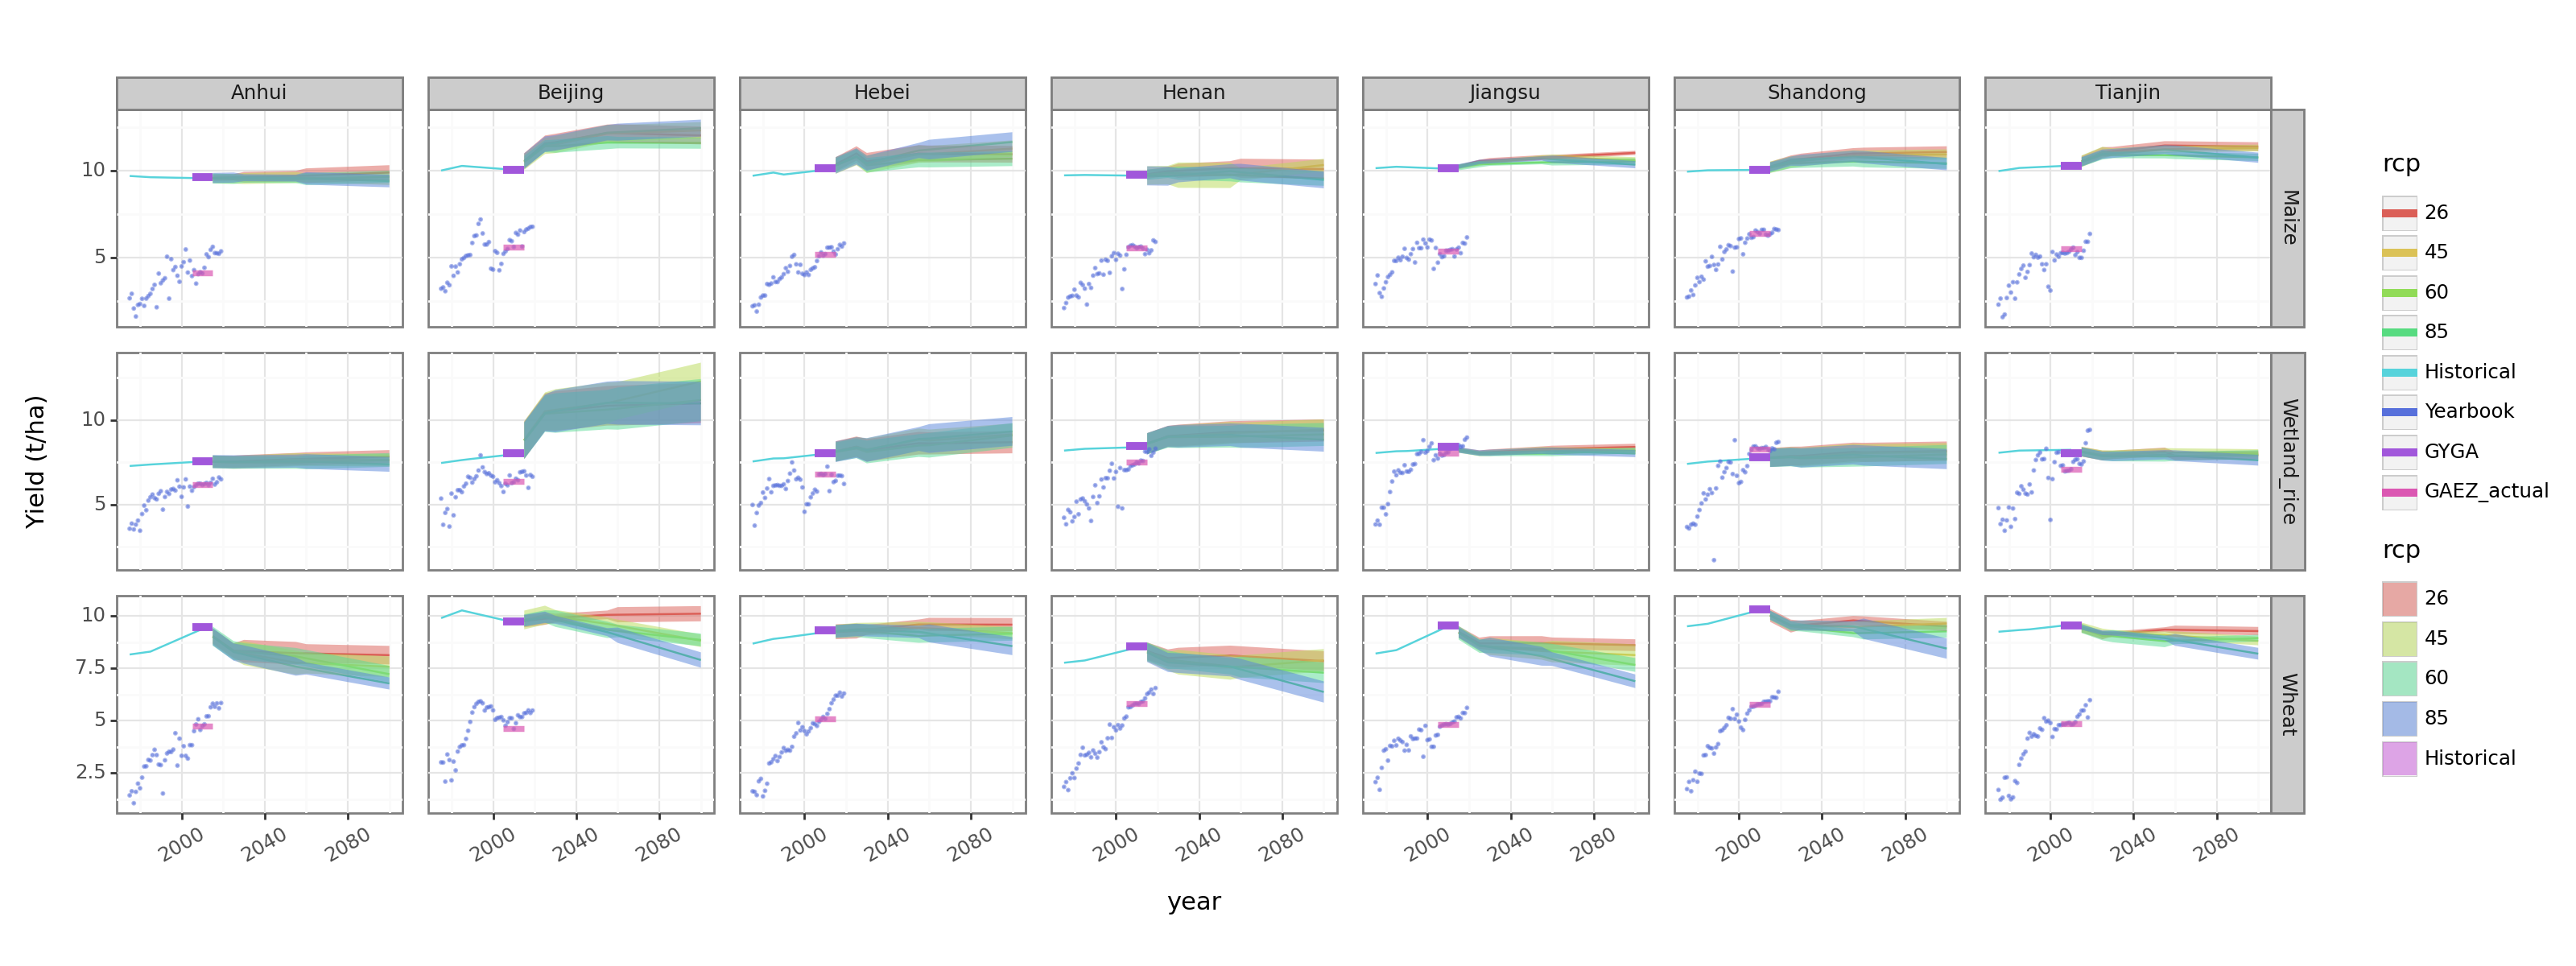

<Figure Size: (1600 x 600)>

In [7]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

### Propagate the GAEZ_actual_yield_2010 to 2100 with the attainable_yield_multiplier
- multiplier_2050 = attainable_2050 / attainable_2010
- yield_2050 = actual_yield_2010 * multiplier_2050

#### Compute the attainable multiplier 

In [8]:
# function to compute the multiplier
def compute_multiplier(row):

  # get row information 
  crop = row['crop']
  water = row['water']
  img_2010 = GAEZ_attainable_t_ha_forced_with_GYGA[(GAEZ_attainable_t_ha_forced_with_GYGA['crop']==crop)&
                             (GAEZ_attainable_t_ha_forced_with_GYGA['water']==water)&
                             (GAEZ_attainable_t_ha_forced_with_GYGA['year']==2010)]['image_mul'].tolist()[0]
  
  # divide row['img'] with img_2010 to get the multiplierd
  multiplier = row['image_mul'].divide(img_2010)

  return multiplier

In [9]:
# 1) get the future attainable yield
GAEZ_attainable_multiplier = GAEZ_attainable_t_ha_forced_with_GYGA.copy()

# 2) compute the multiplier
GAEZ_attainable_multiplier['multiplier_mean'] = GAEZ_attainable_multiplier.apply(lambda x:compute_multiplier(x),1)
GAEZ_attainable_multiplier = GAEZ_attainable_multiplier[['crop','water','year','rcp','multiplier_mean','img_future_sd']]

#### Multiply GAEZ_actual_yield_2010 with GAEZ_attainable_multiplier

In [10]:
# 1) merge yield with multiplier
GAEZ_actual_yield_propogated = GAEZ_attainable_multiplier.merge(right=GAEZ_actual_forced_with_Yearbook,on=['crop','water'])

# 2) yield * multiplier
GAEZ_actual_yield_propogated['propogated_yield'] = GAEZ_actual_yield_propogated.apply(lambda x: 
                                x['image'].multiply(ee.Image(x['multiplier_mean'])),axis=1)

# 3) select only necessary cols, and rename them
GAEZ_actual_yield_propogated.rename({'image':'actual_yield_2010',"year_x":'year',"rcp_x":'rcp'},axis=1,inplace=True)
GAEZ_actual_yield_propogated = GAEZ_actual_yield_propogated[['crop','water','year','rcp','propogated_yield','img_future_sd']]

GAEZ_actual_yield_propogated.to_pickle('./result_csv/GAEZ_actual_yield_propogated.pkl')

#### Check if the propagation is successful

In [11]:
def compute_area_weighted_mean(df):

  ##################### Multiply each crop_water with its area_ratio #############
  # read the harvested area ratio so we can compute the weigted mean attainable yield
  area_ratio = pd.read_pickle('./result_csv/harvested_area_ratio.pkl')
  df = df.merge(area_ratio,on=['crop','water'])

  # compute the area_weighted actual yield
  df['val_area_weighted'] = df.apply(lambda x:x['propogated_yield'].multiply(x['area_ratio']),1)
  df['sd_area_weighted'] = df.apply(lambda x:ee.Image(x['img_future_sd']).multiply(x['area_ratio']),1)

  ##################### Sum the area_weighted yield #############
  stats_dict = {}
  for idx,df in df.groupby(['crop','year','rcp']):

    img_val = ee.ImageCollection(df['val_area_weighted'].tolist()).sum()
    img_sd = ee.ImageCollection(df['sd_area_weighted'].tolist()).sum()

    stats_dict[idx] = {'img_val':img_val,"img_sd":img_sd}

  ##################### make the stats a sensibel df #############
  out_df = pd.DataFrame(stats_dict).T.reset_index()
  out_df = out_df.rename(columns={'level_0':'crop','level_1':'year','level_2':'rcp'})

  return out_df

In [12]:
# function to get attianable yield for each province
def compute_yield_each_province(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    year = row['year']
    rcp = row['rcp']

    img_val = row['img_val'].toFloat()
    img_ds = ee.Image(0).toFloat() if year<=2010 else row['img_sd'].toFloat()
    img = ee.Image([img_val,img_ds]).rename(['val','sd'])

    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_provinces,reducer='mean',scale=GAEZ_pix_scale).getInfo()

    # get data
    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['val']] for i in stats['features']}).T
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']] 

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production','sd']
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp

    stats_df['top'] = stats_df['Mean Production'] + stats_df['sd']
    stats_df['bot'] = stats_df['Mean Production'] - stats_df['sd']
    
    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [13]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_actual_yield_propogated_area_weighted_mean = compute_area_weighted_mean(GAEZ_actual_yield_propogated)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_actual_yield_propogated_area_weighted_mean_df = parallelize_dataframe(GAEZ_actual_yield_propogated_area_weighted_mean,compute_yield_each_province,40)

GAEZ_actual_yield_propogated_area_weighted_mean_df.to_csv('./result_csv/GAEZ_actual_yield_propogated_area_weighted_mean_df.csv',index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

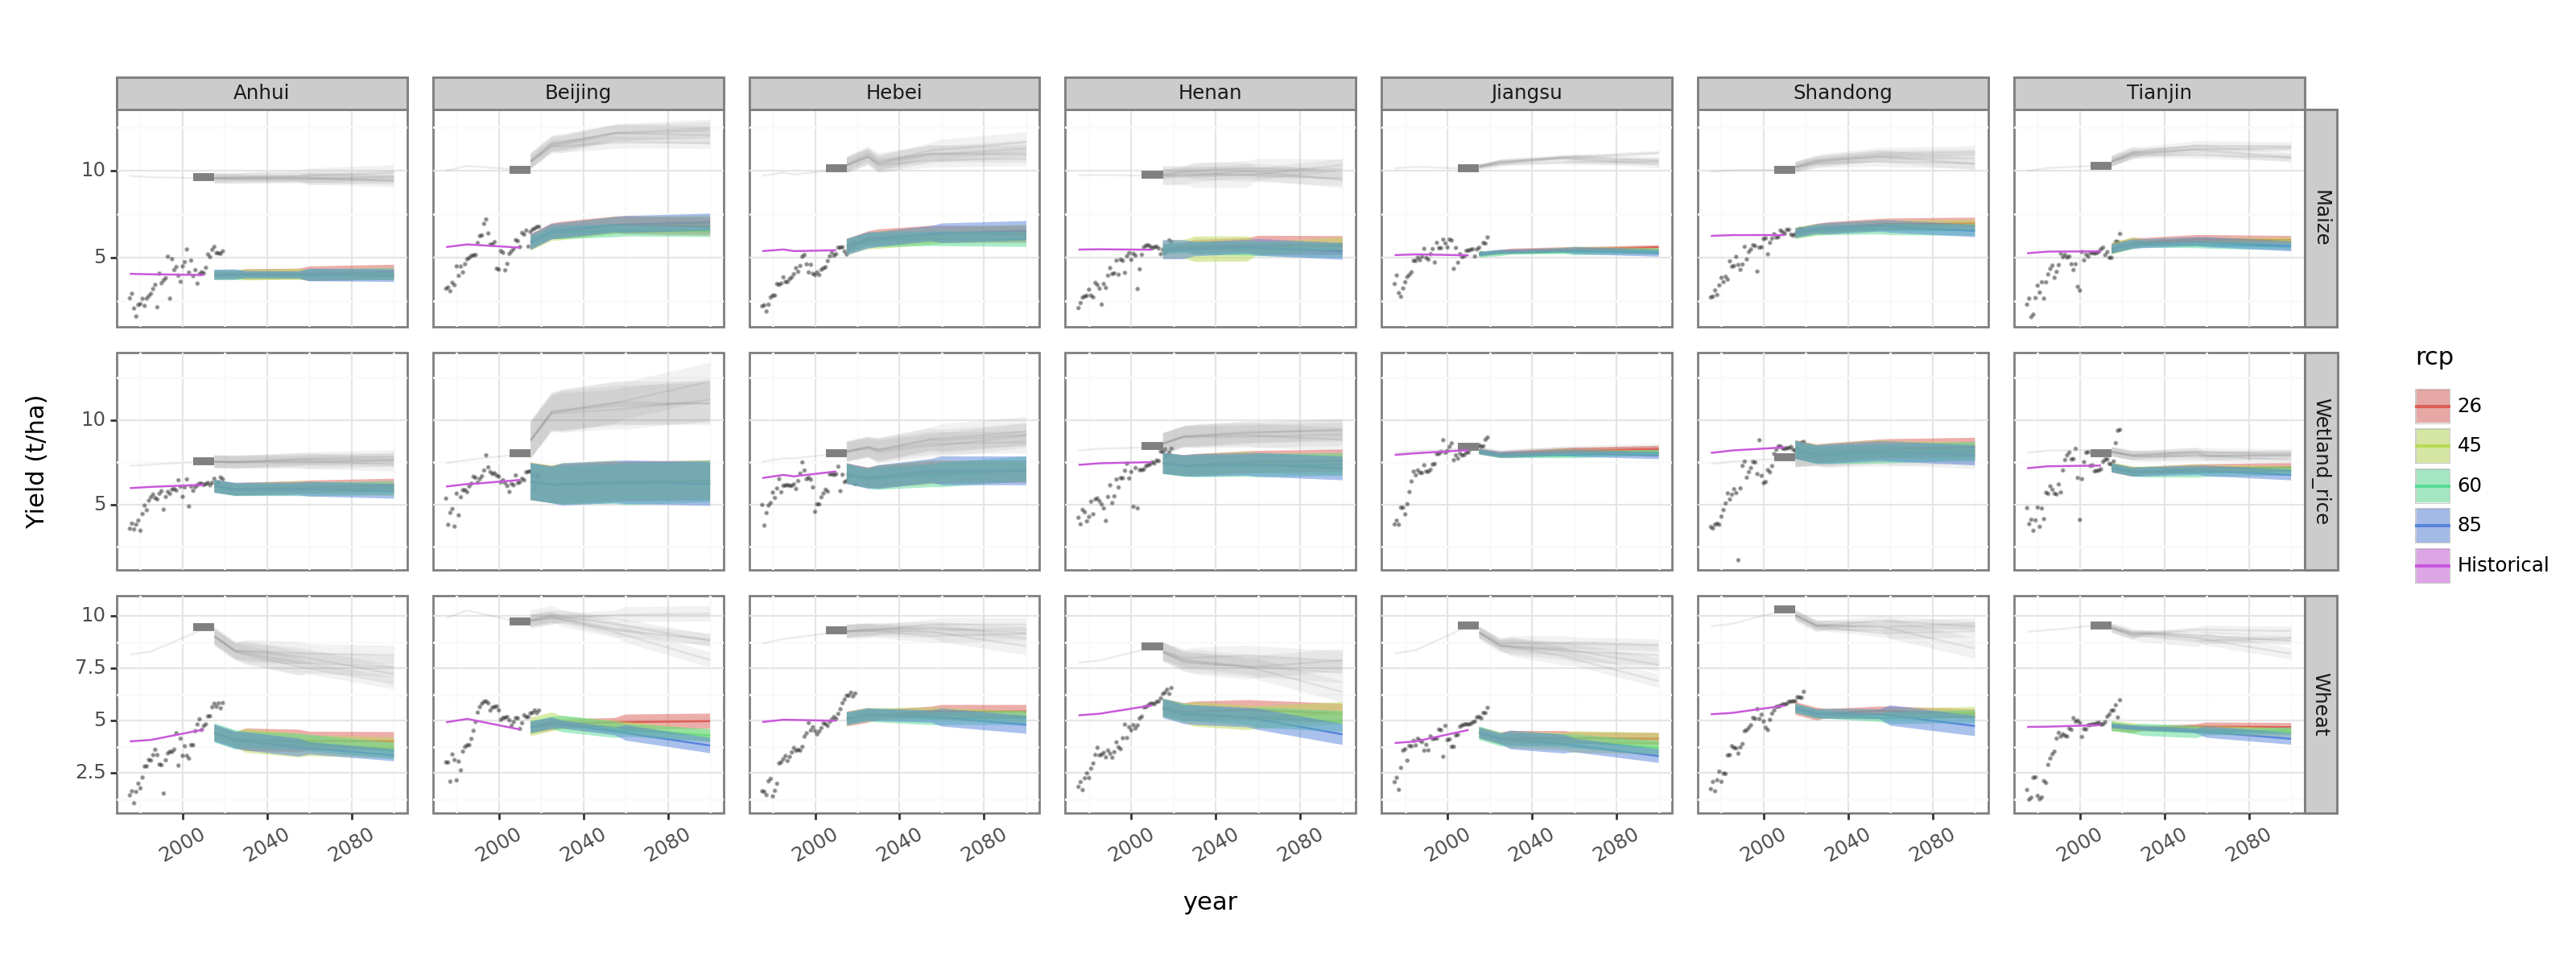

<Figure Size: (1600 x 600)>

In [14]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),alpha=0.3,size=0.2) +
 # GAEZ_attainable_corrected_by_GYGA
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, 
          aes('year','Mean Production',group='rcp'),alpha=0.15,color='grey') +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, 
          aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.1,fill='grey') +
 # GYGA_attainbale_2010
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production'),size=2,color='grey') +
 geom_line(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g

In [15]:
g.save('../Figs/sup_15_yield_propagated_by_attainable.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 16 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_15_yield_propagated_by_attainable.svg
